In [1]:
import matplotlib.pyplot as mp
import pandas as pd
import numpy as np
#import random as rd
#import scipy.special as sps  
#from scipy.optimize import curve_fit
from lmfit import Model
#import threading


In [5]:
def fun_price(mcrpt,a,c,mcreth, fun_thres):
    #calculate g(mcr%) based on
    #<mcrpt> = mcr% = capital pool / mcr
    #<a> and <c> are given constants from the price funciton 
    #<mcreth> is mcr
    #<fun_thres> is when we move from flat price function (disallow redemptions) to mcr%^4 function, currently = 1
    if mcrpt<fun_thres:
        return a+mcreth/c
    else:
        return a+mcreth/c*(mcrpt)**4

In [3]:
def get_steps(a,c,fun_thres, start, end, stepsize,mcr_init,v_init):
    #not used/relevant
    #assuming mcr is constant, get the values for mcr% and price moving up the price curve
    #when using the current step function approach given <stepsize>
    max_iter=100000
    steps=[]
    prices=[]
    mcr=mcr_init
    v=v_init
    mcrpt=v/mcr
    cnt_iter=0
    while (mcrpt<end)& (cnt_iter<max_iter):
        cnt_iter+=1
        mcrpt=v/mcr
        steps.append(mcrpt)
        price = fun_price(mcrpt,a,c,mcr,fun_thres)
        prices.append(price)
        v+=price*stepsize
        
    return {'step':steps,
             'price':prices}

In [4]:
def buy(a,c,fun_thres,cover,mcrshare,eth, v_init, mcr_init, stepsize):
    #simulates buying tokens for <eth> ETH when mcr%= <mcrshare>
    #<a>,<c>,<fun_thres> as in fun_price
    #<v_init> is current level of capital pool in ETH
    #<mcr_init> is current level of mcr in ETH
    #<cover> is amount of cover purchased (set to 0 for simulations)
    #<stepsize> is the number of tokens for which we keep a constant price per the used step function approach
    
    max_iter=100000000 #avoid endless loop
    v=v_init+cover
    mcr=mcr_init+cover #likely some fraction of cover to be added here
    budget = eth-cover
    num_token=0
    cnt_iter=0
    price=0
    increment=0
    
    while (budget>0) & (cnt_iter<max_iter):
        cnt_iter+=1
        if mcrshare <1:
            mcrpt=mcrshare+price*increment/mcr_init
        else:
            mcrpt=v/mcr
        price = fun_price(mcrpt,a,c,mcr,fun_thres)
        purchase_power = budget/price
        if purchase_power//stepsize > 0:
            increment=stepsize
        else:
            increment=purchase_power
        
        v+=price*increment
        num_token+=increment
        budget-=price*increment
        #if cnt_iter%100000==0:
        #    print("iter: %f \n price: %f \n tokens: %f \n budget: %f \n pool: %f"%(cnt_iter,price,num_token,budget,v))
        
        
    return {'num_token':num_token,
            'v':v,
            'mcr':mcr,
            'price_per_token':eth/num_token}

In [32]:
def sell(a,c,fun_thres,cover,mcrshare,nxm, v_init, mcr_init, stepsize):
    #simulates selling <nxm> tokens  when mcr%= <mcrshare>
    #all other variables as in buy - function
    
    max_iter=1000000
    mcr=mcr_init
    v=v_init
    budget = nxm
    burned_token=0
    eth=0
    cnt_iter=0
    while (budget>0) & (cnt_iter<max_iter):
        cnt_iter+=1
        mcrpt=v/mcr
        price = fun_price(mcrpt,a,c,mcr,fun_thres)

        if budget>=stepsize:
            increment=stepsize
        else:
            increment=budget
        
        v-=price*increment
        burned_token+=increment
        budget-=increment
        eth += price*increment
        #print("iter: %f \n price: %f \n tokens: %f \n budget: %f \n pool: %f \n mcrpt: %f \n check: %f"%
        #      (cnt_iter,price,burned_token,budget,v,mcrpt,budget+burned_token))
        
        
    return {'num_token':burned_token,
            'v':np.round(v,2),
            'mcr':mcr,
            'price_per_token':np.round(eth/burned_token,5),
            'total_eth': np.round(eth,2)}

In [81]:
def buy_and_sell(a,c,fun_thres,cover,mcrshare,eth, v_init, mcr_init, stepsize,sell_tax, print_info):
        #calculates the absolute and relative gain one makes by buying tokens for eth ETH and then 
        #selling nxm tokens to receive ETH and then
        #reinvest that ETH to purchase tokens again - since we use the left side of the curve for pricing when buying
        #and the right (higher) side when selling, the larger <stepsize> and the larger <mcrshare> (=higher price per token)
        #the higher the arbitrage opportunity
        #all variables as in buy/sell function
        #<sell_tax> is a parameter to penalize selling tokens (2.5% currently) - question is if this money remains in the capital pool
        #<print_info> is boolean whether to show the buy/sell info
        
        #buy eth ETH
        buy_output = buy(a,c,fun_thres,cover,mcrshare,eth,v_init,mcr_init,stepsize)
        
        #sell all tokens
        tokens = buy_output['num_token']
        v=buy_output['v']
        mcr=buy_output['mcr']
        mcrpt = v/mcr
        sell_output = sell(a,c,fun_thres,cover,mcrpt,tokens,v, mcr, stepsize)
        eth_out = sell_output['total_eth']*(1-sell_tax)
        
        if print_info:
            print('We buy ' + str(eth) + ' ETH at mcr%=' + str(v_init/mcr_init) + ' (v=' + str(v_init)+')\n')
            print('Buy info:\n' + str(buy_output) + '\n')
            print('We sell all tokens to get :\n' + str(sell_output['total_eth']) + '\n')
            print('Applying sell-tax we actually just get ' + str(np.round(eth_out,2)) + ' ETH\n')
            print('Sell info:\n' + str(sell_output))
        
        arbitrage={}
        if eth_out-eth>0:
            arbitrage['abs'] = eth_out-eth
            arbitrage['rel'] = (eth_out-eth)/eth
        else:
            arbitrage['abs'] = 0
            arbitrage['rel'] = 0
            
        
        return arbitrage
    

## Initialize parameters

In [9]:
a=0.01028
c=5800000
v_init=15000
mcr_init=v_init
cover=0
mcr_thres=1 #if mcr < this, then price function is flat (no redemptions)
token_init = 0
start=0.8 #start of range of mcr% values
end=10 #end of range of mcr% values

xrange_grid=0.01/mcr_init #stepsize for ideal curve
xrange=np.arange(start,end,xrange_grid)


In [ ]:
y_price=[fun_price(xval,a,c,mcr_init,mcr_thres) for xval in xrange] #price function per whitepaper

In [ ]:
y_int_dx=[fun_price(xval,a,c,mcr_init,mcr_thres)*xrange_grid for xval in xrange] #step function approach - left price points of rectangle

In [ ]:
y_int_cs=np.cumsum(y_int_dx) #approximate 'ideal' integral with very finegrained (=xrange_grid) summation
y_int_cs+=y_price[0]*start #account for fact that xrane doesnt start at 0

# Fitted curves

In [363]:
def func_fit(x, a,b):
    #global fit, y_price[0]-a condition is to make funciton continous at mcr%=1
        return a * x**b + y_price[0]-a

In [711]:
def func_fit_2(x,a,b):
    #local fit - first run above for region 1 fit (until xrange[2000000]),
    # then run y_price[0]-a condition is to make funciton continous at mcr%=1
    return a*x**b + 0.00302574*xrange[2000000]**3.28048726+  y_price[0]-0.00302574 - a*xrange[2000000]**b

In [417]:
def func_exp(x,a,b,c):
    #fit exponential function (also with condition to be continous at mcr%=1)
    return a*np.exp(b*(x-c))+y_price[0]-a*np.exp(b*(1-c))

In [696]:
#run this for global fit or local fit region 1 (xrange is set for region 1 of local fit right now)
fmodel = Model(func_fit)
params = fmodel.make_params(a=1,b=0.1)

result = fmodel.fit(y_int_cs[240000:2000000], params, x=xrange[240000:2000000])
print(result.fit_report())


[[Model]]
    Model(func_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 151
    # data points      = 1760000
    # variables        = 2
    chi-square         = 0.11574000
    reduced chi-square = 6.5761e-08
    Akaike info crit   = -29105526.7
    Bayesian info crit = -29105501.9
[[Variables]]
    a:  0.00302574 +/- 3.5897e-07 (0.01%) (init = 1)
    b:  3.28048726 +/- 1.5987e-04 (0.00%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.994


In [712]:
#run this for local fit region 2 (i.e. mcr%>xrange[2000000]~2.133)
fmodel = Model(func_fit_2)
params = fmodel.make_params(a=1,b=4.5)

result = fmodel.fit(y_int_cs[2000000:7000000], params, x=xrange[2000000:7000000])
print(result.fit_report())


[[Model]]
    Model(func_fit_2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 5000000
    # variables        = 2
    chi-square         = 23.7690068
    reduced chi-square = 4.7538e-06
    Akaike info crit   = -61282825.9
    Bayesian info crit = -61282799.0
[[Variables]]
    a:  6.1028e-04 +/- 1.2071e-08 (0.00%) (init = 1)
    b:  4.91016275 +/- 1.2172e-05 (0.00%) (init = 4.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.999


In [46]:
def fun_int(mcrpt, a,c,mcreth,mcr_thres):
    #based on global fit (300k:7000k in xrange)
    
    param_a1=6.7390e-04
    param_b1=4.85233270
    if mcrpt<mcr_thres:
        return fun_price(mcrpt,a,c,mcreth,mcr_thres)*mcrpt
    else:
        return param_a1*mcrpt**param_b1+y_price[0]-param_a1

In [47]:
def fun_int_2(mcrpt, a,c,mcreth,mcr_thres):
     #based on 2 local fits, 1) 300k:2400k, 2) (300k:7000k in xrange)
    param_a1 = 0.00302574
    param_b1 = 3.28048726
    param_a2 = 6.1028e-04
    param_b2 = 4.91016275
    if mcrpt<mcr_thres:
        return fun_price(mcrpt,a,c,mcreth,mcr_thres)*mcrpt
    else:
        if mcrpt<xrange[2000000]:
            return param_a1*mcrpt**param_b1+  y_price[0]- param_a1
        else:
            return param_a2*mcrpt**param_b2+ param_a1*xrange[2000000]**param_b1+  y_price[0]-param_a1 - param_a2*xrange[2000000]**param_b2

In [423]:
def fun_int_exp(mcrpt, a,c,mcreth,mcr_thres):
     #based on 2 local fits, 1) 300k:2400k, 2) (300k:7000k in xrange)
    param_a = 101.302367 
    param_b = 3.58128484
    param_c = 1046.57276
    if mcrpt<mcr_thres:
        return fun_price(mcrpt,a,c,mcreth,mcr_thres)*mcrpt
    else:
        return param_a*np.exp(param_b*(mcrpt-param_c))+y_price[0]-param_a*np.exp(param_b*(1-param_c))

In [402]:
#global fitted curve
y_int_fit = [fun_int(xval,a,c,mcr_init,mcr_thres) for xval in xrange]

In [714]:
#local fitted curve
y_int_fit_2 = [fun_int_2(xval,a,c,mcr_init,mcr_thres) for xval in xrange]

In [725]:
buy(a,c,1,0,1,1,15000,15000,1)
#buy(a,c,fun_thres,cover,mcrshare,eth, v_init, mcr_init, stepsize):

{'num_token': 77.72092817578866,
 'v': 15001.000000000004,
 'mcr': 15000,
 'price_per_token': 0.012866547318351717}

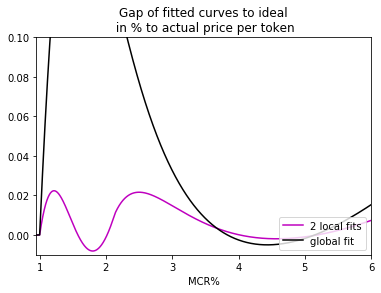

In [764]:
#Compare the ideal curve and fitted curves
#mp.plot(samplerange[1:],df_out[(df_out.stepsize==0)&(df_out.buypower_eth==1)].price)
#mp.plot(xrange,y_int_dx)
mp.plot(xrange,(np.array(y_int_cs)-np.array(y_int_fit_2))/y_price,colors[3],label=labels[3])
mp.plot(xrange,(np.array(y_int_cs)-np.array(y_int_fit))/y_price, colors[2],label=labels[2])
#mp.plot(xrange,(np.array(y_int_fit)))
mp.xlim(0.95,6)
mp.ylim(-0.01,0.1)
mp.xlabel('MCR%')
mp.title('Gap of fitted curves to ideal\n in % to actual price per token')
mp.legend(loc='lower right')
#mp.plot(out['step'],np.log(out['price']))

(0.01, 0.2)

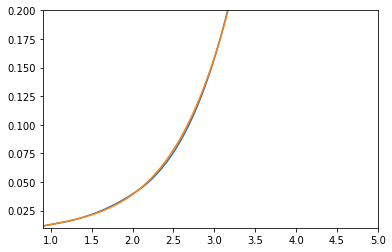

In [665]:
mp.plot(xrange,y_int_fit_2)
mp.plot(xrange,y_int_cs)
mp.xlim(0.9,5)
mp.ylim(0.01,0.2)

0.013234744741418374

In [59]:
#simulate purchase of <buypower_eth> ETH at different mcr% levels given by <stepsizes>
#basis for charts
stepsizes=[-3,-2,-1,0,1,10,100,1000,10000]
buypower_eth = [1,10,100,1000]
samplerange=np.arange(0.8,end-0.1,0.05)
cnt=0
output={}
output['price']=[]
output['stepsize']=[]
output['buypower_eth']=[]
output['token']=[]
output['mcrpt_delta']=[]
output['baseprice']=[]
output['endprice']=[]
output['posstart']=[]
output['posend']=[]
output['xstart']=[]
output['xend']=[]
output['mcrpt']=[]
output['v']=[]
output['v_delta']=[]
output['yint']=[]

In [719]:



for stepsize in stepsizes:
    for eth in buypower_eth:
        mcr=mcr_init
        v=v_init
        #print('iteration eth: ' + str(eth) + '\n' + 'stepsize: ' + str(stepsize) + '\n')
        for i in range(0,len(samplerange)):
            mcrpt=samplerange[i]
            mcrpt_new=mcrpt+eth/mcr
            
            output['mcrpt'].append(mcrpt)
            output['mcrpt_delta'].append((mcrpt_new-mcrpt))
            pos_start=np.where(xrange>=mcrpt)
            pos_end=np.where(xrange>=mcrpt_new)
            #print(pos_end)
            output['posstart'].append(xrange[pos_start[0][0]])
            output['posend'].append(xrange[pos_end[0][0]])
            output['xstart'].append(pos_start[0][0])
            output['xend'].append(pos_end[0][0])
            output['baseprice'].append(y_price[pos_start[0][0]])
            output['endprice'].append(y_price[pos_end[0][0]])
            
            if samplerange[i]<1:
                v=v_init
            else:
                v=mcr*samplerange[i]
            
            if stepsize ==-3: #cumsum
                #price_yint=np.sum(y_int_dx[pos_start[0][0]:pos_end[0][0]]) + y_price[pos_start[0][0]]
                yint_val=(y_int_cs[pos_end[0][0]]-y_int_cs[pos_start[0][0]])
                price_yint=yint_val/(mcrpt_new-mcrpt)
                output['yint'].append(yint_val)
                output['price'].append(price_yint)
                output['token'].append(eth/price_yint)
            else:
                if stepsize ==-2: #sum_function (to check)
                    yint_val=0
                    price_yint=np.sum(y_int_dx[pos_start[0][0]:pos_end[0][0]]) + y_price[pos_start[0][0]]
                    #price_yint=(y_int_fit_exp[pos_end[0][0]]-y_int_fit_exp[pos_start[0][0]])/(mcrpt_new-mcrpt)
                    output['yint'].append(yint_val)
                    output['price'].append(price_yint)
                    output['token'].append(eth/price_yint)
                else:
                    if stepsize ==-1: #fitted global
                        yint_val=(y_int_fit[pos_end[0][0]]-y_int_fit[pos_start[0][0]])
                        price_yint=yint_val/(mcrpt_new-mcrpt)
                        #final_price=price_yint
                        output['yint'].append(yint_val)
                        output['price'].append(price_yint)
                        output['token'].append(eth/price_yint)
                    else:
                        if stepsize ==0: #fitted twofold
                            yint_val=(y_int_fit_2[pos_end[0][0]]-y_int_fit_2[pos_start[0][0]])
                            price_yint=yint_val/(mcrpt_new-mcrpt)
                            #final_price=price_yint   
                            output['yint'].append(yint_val)
                            output['price'].append(price_yint)
                            output['token'].append(eth/price_yint)
                        else:
                            purchase_output=buy(a,c,mcr_thres,cover,mcrpt,eth, v, mcr, stepsize)
                            yint_val=0
                            output['yint'].append(yint_val)
                            output['price'].append(purchase_output['price_per_token'])
                           # print(str(xrange[pos_start[0][0]]) + '\n' + str(xrange[pos_end[0][0]]) + '\n'
                           # + str(purchase_output['price_per_token']) + '\n' +
                           #       str(purchase_output['v'])+ '\n' + str(purchase_output['mcr']) + '\n\n')
                            output['token'].append(purchase_output['num_token'])
  


            output['v'].append(v)
            output['v_delta'].append(eth)
            output['stepsize'].append(stepsize)
            output['buypower_eth'].append(eth)
            
        #print(str(len(output['price'])) + '\n' + str(len(output['token'])) + '\n' 
        #      + str(len(output['stepsize'])) + '\n' + str(len(output['buypower_eth'])))
              
df_out=pd.DataFrame(output)

In [744]:
#check output for some params
df_out[(df_out.stepsize==0)&(df_out.buypower_eth==1)][['mcrpt','mcrpt_delta','xstart','xend','posstart','posend','yint','price','v','token','baseprice','endprice']].iloc[:10]

,mcrpt,mcrpt_delta,xstart,xend,posstart,posend,yint,price,v,token,baseprice,endprice
2184,0.80,0.000067,0,101,0.800000,0.800067,8.663246e-07,0.012995,15000.0,76.953450,0.012866,0.012866
2185,0.85,0.000067,75001,75101,0.850001,0.850067,8.577471e-07,0.012866,15000.0,77.722985,0.012866,0.012866
2186,0.90,0.000067,150001,150101,0.900001,0.900067,8.577471e-07,0.012866,15000.0,77.722985,0.012866,0.012866
2187,0.95,0.000067,225001,225101,0.950001,0.950067,8.577471e-07,0.012866,15000.0,77.722985,0.012866,0.012866
2188,1.00,0.000067,300001,300101,1.000001,1.000067,6.617781e-07,0.009927,15000.0,100.738705,0.012866,0.012867
2189,1.05,0.000067,375001,375101,1.050001,1.050067,7.396610e-07,0.011095,15750.0,90.131384,0.013424,0.013424
2190,1.10,0.000067,450001,450101,1.100001,1.100067,8.224411e-07,0.012337,16500.0,81.059503,0.014066,0.014067
2191,1.15,0.000067,525001,525101,1.150001,1.150067,9.101828e-07,0.013653,17250.0,73.245358,0.014803,0.014804
2192,1.20,0.000067,600001,600101,1.200001,1.200067,1.002948e-06,0.015044,18000.0,66.470685,0.015643,0.015644
2193,1.25,0.000067,675001,675101,1.250001,1.250067,1.100798e-06,0.016512,18750.0,60.562117,0.016594,0.016595


In [746]:
df_out[(df_out.stepsize==-3)&(df_out.buypower_eth==1)][['mcrpt','mcrpt_delta','xstart','xend','posstart','posend','yint','price','v','token','baseprice','endprice']].iloc[:10]
                                                                                                                                           

,mcrpt,mcrpt_delta,xstart,xend,posstart,posend,yint,price,v,token,baseprice,endprice
0,0.80,0.000067,0,101,0.800000,0.800067,8.663246e-07,0.012995,15000.0,76.953450,0.012866,0.012866
1,0.85,0.000067,75001,75101,0.850001,0.850067,8.577471e-07,0.012866,15000.0,77.722985,0.012866,0.012866
2,0.90,0.000067,150001,150101,0.900001,0.900067,8.577471e-07,0.012866,15000.0,77.722985,0.012866,0.012866
3,0.95,0.000067,225001,225101,0.950001,0.950067,8.577471e-07,0.012866,15000.0,77.722985,0.012866,0.012866
4,1.00,0.000067,300001,300101,1.000001,1.000067,8.577708e-07,0.012867,15000.0,77.720839,0.012866,0.012867
5,1.05,0.000067,375001,375101,1.050001,1.050067,8.949308e-07,0.013424,15750.0,74.493656,0.013424,0.013424
6,1.10,0.000067,450001,450101,1.100001,1.100067,9.377959e-07,0.014067,16500.0,71.088675,0.014066,0.014067
7,1.15,0.000067,525001,525101,1.150001,1.150067,9.869221e-07,0.014804,17250.0,67.550077,0.014803,0.014804
8,1.20,0.000067,600001,600101,1.200001,1.200067,1.042891e-06,0.015643,18000.0,63.924835,0.015643,0.015644
9,1.25,0.000067,675001,675101,1.250001,1.250067,1.106312e-06,0.016595,18750.0,60.260293,0.016594,0.016595


In [492]:
#just some checks
buy(a,c,mcr_thres,0,0.80, 15000*0.15, 0.8*15000,15000, 1)
#buy(a,c,fun_thres,cover,mcrshare,eth, v_init, mcr_init, stepsize):

{'num_token': 174876.71526536602,
 'v': 14249.999999972828,
 'mcr': 15000,
 'price_per_token': 0.012866206896588525}

## Charts

In [60]:
#labels for chart legend
labels = [''] * len(stepsizes)
labels[0]='ideal'
labels[1]='ideal(check)'
labels[2]='global fit'
labels[3]='2 local fits'
labels[4:]=['stepsize: ' + str(s) for s in stepsizes[4:]]
#keep colors the same through plots
colors=['k','w','k','m','#abbde5','#7a9be4','#3169e1','r','#ddb1b1']

No handles with labels found to put in legend.


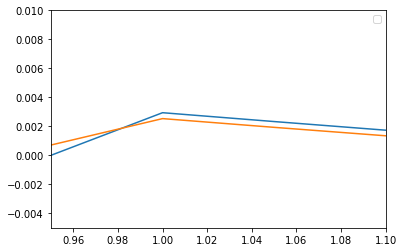

In [733]:
#just for checks, not relevant
j=3
#range(0,len(buypower_eth),3)
for i in [0,3]:
    tmp_base = df_out[(df_out.stepsize==-3)&(df_out.buypower_eth==buypower_eth[i])]
    tmp_comp = df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])]
    mp.plot(samplerange,
            (np.array(tmp_base.price)-np.array(tmp_comp.price))
            #,label=labels[j]
           )
    mp.xlim(0.95,1.1)
    mp.ylim(-0.005,0.01)
mp.legend()
#mp.title(buypower_eth[i])

In [50]:
#price curve (price per token given mcr% on x axis) based on differnt approximations
i=0
for j in range(0,len(stepsizes)):
    tmp_base = df_out[(df_out.stepsize==-3)&(df_out.buypower_eth==buypower_eth[i])]
    tmp_comp = df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])]
    mp.plot(samplerange,
            (np.array(tmp_comp.price))
            ,label=labels[j]
           )
    mp.xlim(0.8,2.5)
    mp.ylim(0,0.1)
mp.legend()
mp.title(buypower_eth[i])

NameError: name 'stepsizes' is not defined

Text(0.5, 0.98, 'Gap in ETH to ideal when buying e ETH')

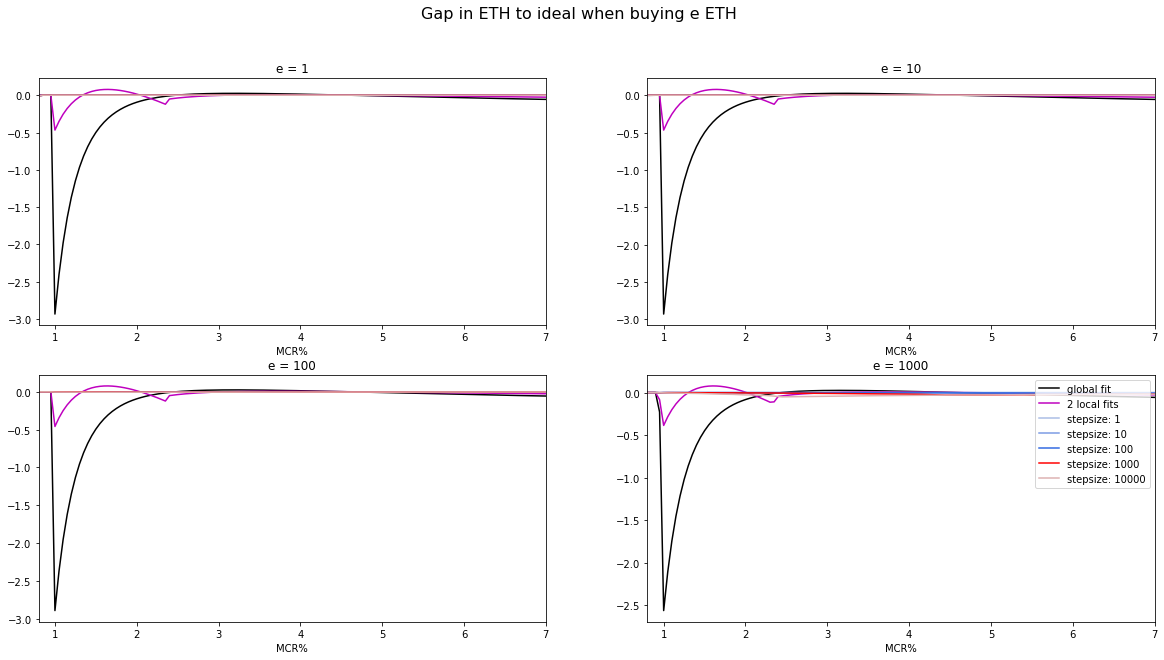

In [526]:
#plot of absolute deviation in terms of tokens
ylims=[0.015,0.02,0.03,0.05]
fig, axs = mp.subplots(2, 2,figsize=(20, 10))

for i in range(0,len(buypower_eth)):
    for j in range(2,len(stepsizes)):
        tmp_base = df_out[(df_out.stepsize==-3)&(df_out.buypower_eth==buypower_eth[i])]
        tmp_comp = df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])]
        axs[i//2,i%2].plot(samplerange,
                (np.array(tmp_base.token)-np.array(tmp_comp.token))/(np.array(tmp_base.token)),
                colors[j],
                label=labels[j])
        axs[i//2,i%2].set_title('e = ' + str(buypower_eth[i]))
        axs[i//2,i%2].set_xlabel('MCR%')
#        mp.xlim(0.8,1.5)
        axs[i//2,i%2].set_xlim(0.8,7)
#        axs[i//2,i%2].set_ylim(-0.01,ylims[i])
mp.legend(loc='upper right')
fig.suptitle('Gap in ETH to ideal when buying e ETH', fontsize=16)
#for ax in axs.flat:
#    ax.label_outer()

Text(0.5, 0.98, 'Gap in ETH to ideal when buying e ETH')

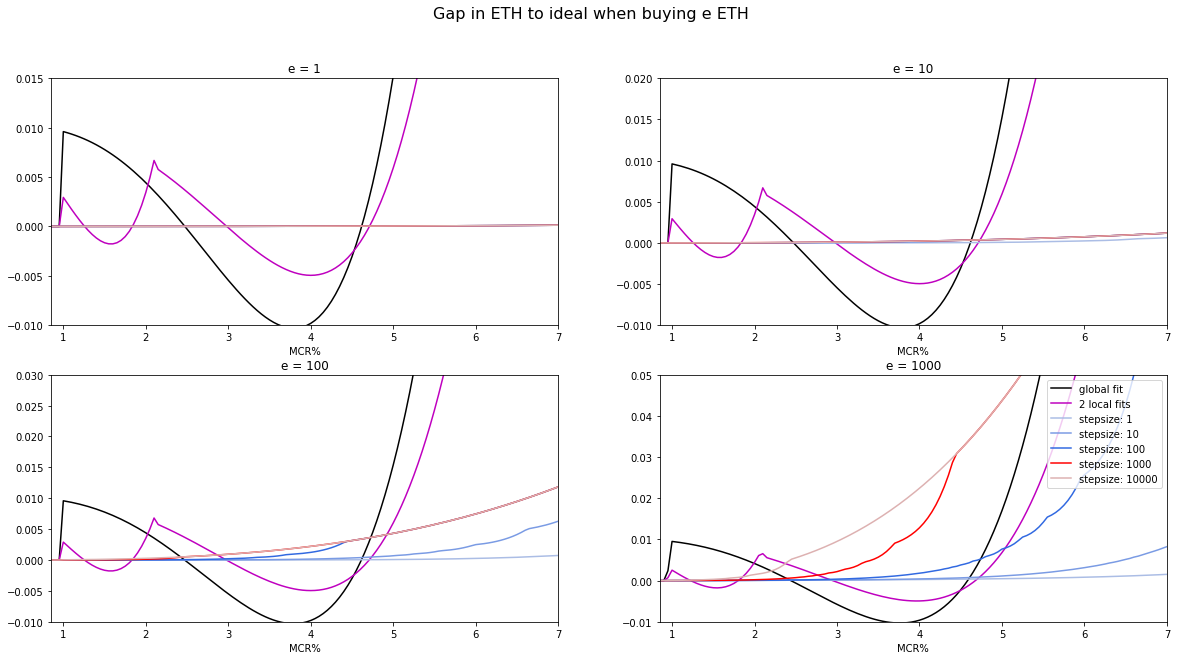

In [767]:
#plot of absolute deviation
ylims=[0.015,0.02,0.03,0.05]
fig, axs = mp.subplots(2, 2,figsize=(20, 10))

for i in range(0,len(buypower_eth)):
    for j in range(2,len(stepsizes)):
        tmp_base = df_out[(df_out.stepsize==-3)&(df_out.buypower_eth==buypower_eth[i])]
        tmp_comp = df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])]
        axs[i//2,i%2].plot(samplerange,
                (np.array(tmp_base.price)-np.array(tmp_comp.price)),
                colors[j],
                label=labels[j])
        axs[i//2,i%2].set_title('e = ' + str(buypower_eth[i]))
        axs[i//2,i%2].set_xlabel('MCR%')
#        mp.xlim(0.8,1.5)
        axs[i//2,i%2].set_xlim(0.85,7)
        axs[i//2,i%2].set_ylim(-0.01,ylims[i])
mp.legend(loc='upper right')
fig.suptitle('Gap in ETH to ideal when buying e ETH', fontsize=16)
#for ax in axs.flat:
#    ax.label_outer()

Text(0.5, 0.98, 'Gap to ideal when buying e ETH \n (in % to price level post purchase)')

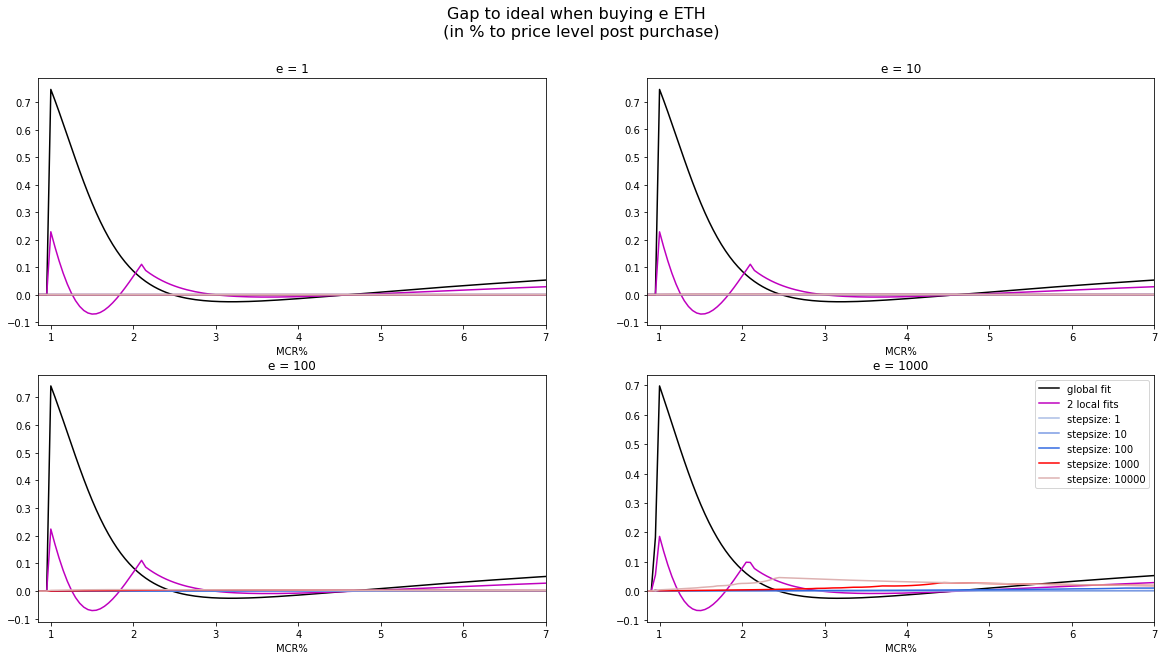

In [769]:
#plot of relative deviation
fig, axs = mp.subplots(2, 2,figsize=(20, 10))
#ylims=[0.15,0.02,0.03,0.05]
for i in range(0,len(buypower_eth)):
    for j in range(2,len(stepsizes)):
        tmp_base = df_out[(df_out.stepsize==-3)&(df_out.buypower_eth==buypower_eth[i])]
        tmp_comp = df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])]
        axs[i//2,i%2].plot(samplerange,
                (np.array(tmp_base.price)-np.array(tmp_comp.price))/(np.array(tmp_base.endprice)),
                colors[j],
                label=labels[j])
        axs[i//2,i%2].set_title('e = ' + str(buypower_eth[i]))
        axs[i//2,i%2].set_xlabel('MCR%')
#        mp.xlim(0.8,1.5)
        axs[i//2,i%2].set_xlim(0.85,7)
        #if i==0:
        #    axs[i//2,i%2].set_ylim(0,0.0001)
mp.legend(loc='upper right')
fig.suptitle('Gap to ideal when buying e ETH \n (in % to price level post purchase)', fontsize=16)
#for ax in axs.flat:
#    ax.label_outer()

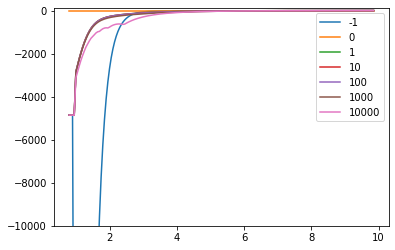

In [70]:
i=3
for j in range(1,len(stepsizes)):
    tmp_base = df_out[(df_out.stepsize==-2)&(df_out.buypower_eth==buypower_eth[i])]
    tmp_comp = df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])]
    mp.plot(samplerange,
            np.array(df_out[(df_out.stepsize==0)&(df_out.buypower_eth==buypower_eth[i])].token)-np.array(df_out[(df_out.stepsize==stepsizes[j])&(df_out.buypower_eth==buypower_eth[i])].token),
            label=stepsizes[j])
#    mp.xlim(1,2)
    mp.ylim(-10000,100)
mp.legend()

## Analysis on arbitrage opportunity

In [43]:
sell_and_buy(a,c,1,0,3,10000,15000*3,15000,1000,0,True)

We sell 10000 token at mcr%=3.0 (v=45000)

Sell info:
{'num_token': 10000, 'v': 42970.44, 'mcr': 15000, 'price_per_token': 0.20296, 'total_eth': 2029.56}

Applying sell-tax we actually just get 2029.56 ETH

Buy info:
{'num_token': 10173.828605246174, 'v': 45000.00000000001, 'mcr': 15000, 'price_per_token': 0.1994883223168756}


{'token': 173.82860524617354, 'eth': 2.2737367544323206e-12}

In [ ]:
mcrpt_range=np.arange(1,10,0.1)
mcr_inits = [15000,50000,100000,150000,200000,500000]
arbitrage_out={}
arbitrage_out['eth_used']=[]
arbitrage_out['mcr_init']=[]
arbitrage_out['mcrpt']=[]
arbitrage_out['abs']=[]
arbitrage_out['rel']=[]
sell_tax=0.025
stepsize=1000
eth_arbitrages = [100,1000,10000]

for mcr_init in mcr_inits:
    for eth_arbitrage in eth_arbitrages:
        for mcrpt in mcrpt_range:
            out = buy_and_sell(a,c,mcr_thres,cover,mcrpt,eth_arbitrage,mcr_init*mcrpt,mcr_init,stepsize,sell_tax,False)
            arbitrage_out['mcrpt'].append(mcrpt)
            arbitrage_out['abs'].append(out['abs'])
            arbitrage_out['rel'].append(out['rel'])
            arbitrage_out['eth_used'].append(eth_arbitrage)
            arbitrage_out['mcr_init'].append(mcr_init)

df_arbitrage=pd.DataFrame(arbitrage_out)

In [86]:
df_arbitrage

,mcrpt,abs,rel
0,1.0,0.00000,0.000000
1,1.1,0.00000,0.000000
2,1.2,0.00000,0.000000
3,1.3,0.00000,0.000000
4,1.4,0.00000,0.000000
5,1.5,0.00000,0.000000
6,1.6,0.00000,0.000000
7,1.7,0.00000,0.000000
8,1.8,0.00000,0.000000
9,1.9,0.00000,0.000000


In [70]:
128.66-15000+14871.34

0.0

Text(0.5, 0, '')

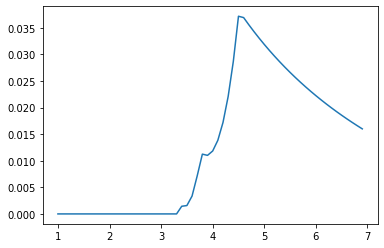

In [93]:
eth_used=1000
mcr_used=150000
tmp = df_arbitrage[(df_arbitrage['eth_used']==eth_used)&(df_arbitrage['mcr_init']==mcr_used)]
mp.plot(tmp.mcrpt,tmp.abs)
mp.xlabel('MCR%')
mp.ylabel('ETH')
mp.title('Absolute arbitrage using ' + str(eth_used) + ' at MCR=' + str(mcr_used))
mp.plot(tmp.mcrpt,tmp.rel)
mp.xlabel('MCR%')
mp.ylabel('% of ETH used')
mp.title('Relative arbitrage using ' + str(eth_used) + ' at MCR=' + str(mcr_used))